In [1]:
import numpy as np
import pandas as pd
import scipy
from matplotlib import pyplot as plt
import os
import sys
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, matthews_corrcoef
from imblearn.over_sampling import SMOTE
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.inspection import permutation_importance
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.metrics import Recall

Im vorliegenden Notebook wird der Deep-Learning-Ansatz erweitert. Die Datenvorverarbeitungsschritte sind in großen Teilen identisch mit denen,
die bei den klassischen ML-Verfahren angewendet wurden. Im Anschluss daran wird unser neuer Ansatz, ein Deep Neural Decision Tree, untersucht.

In [2]:
current_dir = os.getcwd()
file_path = os.path.join(os.path.dirname(current_dir), "data", "raw", "covid19-dataset", "Covid Data.csv")
df = pd.read_csv(file_path)

In [3]:
def get_scores(y_test, y_pred):
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    mcc = matthews_corrcoef(y_test, y_pred)
    return acc, f1, prec, rec, mcc

In [4]:
df['DIED'] = [2 if i=='9999-99-99' else 1 for i in df.DATE_DIED]
df=df.drop(columns='DATE_DIED')
df.loc[df.SEX==2,'PREGNANT']=2
df.loc[df.PATIENT_TYPE==1,'ICU']=2
df.loc[df.PATIENT_TYPE==1,'INTUBED']=2
for col in df.columns.drop('AGE'):
    for i in [97,98, 99]:
        df[col]=df[col].replace(i , np.nan)

df=df.dropna()
df['AGE'] = (df['AGE'] - df['AGE'].min()) / (df['AGE'].max() - df['AGE'].min())

for col in df.columns.drop(['AGE','CLASIFFICATION_FINAL', 'MEDICAL_UNIT', 'PATIENT_TYPE', 'USMER']):
    re_map_dict = {2:0}
    df[col]=df[col].replace(re_map_dict)

df['AT_RISK'] = df['DIED']+df['INTUBED']+df['ICU']
df.AT_RISK = df.AT_RISK.apply(lambda x: 1 if x > 0 else 0) 
target='AT_RISK'

discarded_features = ['MEDICAL_UNIT', 'USMER','DIED','ICU','INTUBED']
df = df.drop(discarded_features, axis=1)

threshold=0.04
selected_features=df.corr()[target][abs(df.corr()[target])>threshold].index
not_selected_features=df.corr()[target][abs(df.corr()[target])<threshold]
print(not_selected_features)
df=df[selected_features]

PREGNANT   -0.017308
ASTHMA     -0.017983
TOBACCO     0.005573
Name: AT_RISK, dtype: float64


In [5]:
#Wir wandeln die kategoriellen Werte des Attributs 'CLASIFFICATION_FINAL' in One-Hot-codierte Dummy-Werte um.
df = pd.get_dummies(df,columns=["CLASIFFICATION_FINAL"],drop_first=True)

In [6]:
#Wir wenden wieder eine Form des balancierten zufälligen Undersamplings an. Zu den Zeilen mit positivem
#Label wird die gleiche Anzahl an Zeilen mit negativem Label zufällig aus der Gesamtmenge aller
#Zeilen mit negativem Label gezogen und konkateniert.

df_dead = df[df["AT_RISK"]==1].copy()
df_alive = df[df["AT_RISK"]==0].sample(n=len(df_dead))

#Wir teilen den Datensatz in Trainings- und Testdatensatz im Verhältnis 90 zu 10 auf. 

test_size_dead=0.1
train_dead, test_dead = train_test_split(df_dead, test_size=test_size_dead, shuffle=True)

test_size_alive=0.1
train_alive, test_alive = train_test_split(df_alive, test_size=test_size_alive, shuffle=True)

train = pd.concat([train_dead, train_alive], axis=0)
test = pd.concat([test_dead, test_alive], axis=0)

train_y = train[target]
train_x = train.drop(target,axis=1)

test_y = test[target]
test_x = test.drop(target,axis=1)

C:\Users\peter\covid-19-risiko-erkennung\venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Best Validation Loss: 0.2348
Best Validation Accuracy: 0.9163
537/537 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
Accuracy: 0.9152581886000699
F1: 0.9184977578475336
Precision: 0.8846776805960479
Recall: 0.9550064110036135
Mcc: 0.8331531824728071



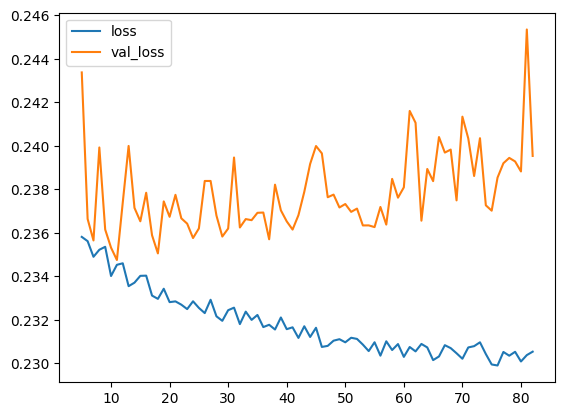

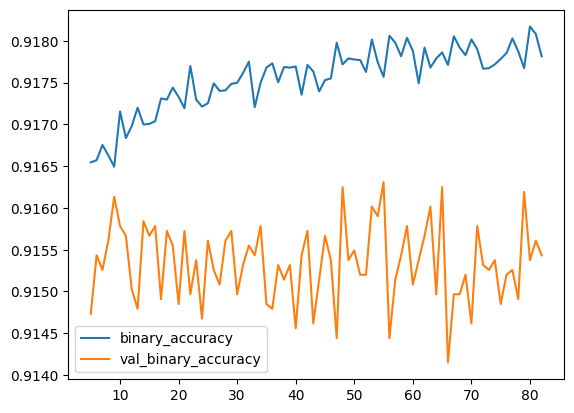

In [7]:
#Wir erweitern die Parameter unseres Multi-Layer-Perzeptrons, indem wir nun vier verdeckte Schichten mit wesentlich
#mehr Neuronen ansetzen. Weiterhin passen wir die Lernrate, den Stopp-Mechanismus und die Batch-Größe an. 

model = keras.Sequential([
        layers.Dense(256, activation='relu', input_shape=[train_x.shape[1]]),
        layers.Dense(1024, activation='relu'),
        layers.Dense(256, activation='relu'),
        layers.Dense(32, activation='relu'),
        layers.Dense(1, activation='sigmoid')])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy'])
model.optimizer.learning_rate.assign(10e-3)

early_stopping = keras.callbacks.EarlyStopping(patience=75, min_delta=0.001, restore_best_weights=True)

history = model.fit(train_x, train_y, validation_data=(test_x, test_y), batch_size=256, epochs=1000,
                    callbacks=[early_stopping], verbose=0)

history_df = pd.DataFrame(history.history)
history_df.loc[5:, ['loss', 'val_loss']].plot()
history_df.loc[5:, ['binary_accuracy', 'val_binary_accuracy']].plot()

print(("Best Validation Loss: {:0.4f}" + "\nBest Validation Accuracy: {:0.4f}").format(history_df['val_loss'].min(),
                  history_df['val_binary_accuracy'].max()))

y_pred = (model.predict(test_x) > 0.5).astype("int32")
acc, f1, prec, rec, mcc = get_scores(test_y, y_pred)
print(f'Accuracy: {acc}')
print(f'F1: {f1}')
print(f'Precision: {prec}')
print(f'Recall: {rec}')
print(f'Mcc: {mcc}'+"\n")


Im Folgenden implementieren wir unseren neuen Ansatz, nämlich den Deep Neural Decision Tree (DNDT). 

In [8]:
import os
import argparse
import time
import pickle
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset
from collections import OrderedDict

In [9]:
#Das verwendete Gerät (GPU oder CPU) wird ausgewählt.

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [10]:
#Der Datensatz muss zuerst in ein passendes Eingabeformat (tabuläres Dataset) für torch umgewandelt werden. 
#Die folgende Klasse definiert die entsprechenden Instanzen.

class TabularDataset(Dataset):
    def __init__(self, features, labels):
        self.features = torch.tensor(features, dtype=torch.float64)
        self.labels = torch.tensor(labels).type(torch.LongTensor)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.features[idx].to(device), self.labels[idx].to(device)


In [11]:
#Die Daten werden in das Eingabeformat umgewandelt. 
train_dataset = TabularDataset(train_x.astype(np.float64).values, train_y.astype(np.float64).values)
test_dataset = TabularDataset(test_x.astype(np.float64).values, test_y.astype(np.float64).values)

#Diese werden Datenlader-Objekten übergeben.
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)

In [16]:
#Die Klasse DNDT implementiert den neuen Ansatz.

class DNDT(nn.Module):
    def __init__(self, depth, num_features, used_features_rate, num_classes):
        super(DNDT, self).__init__()
        self.depth = depth
        self.num_leaves = 2**depth
        self.num_classes = num_classes

        num_used_features = int(num_features * used_features_rate)
        one_hot = np.eye(num_features)
        sampled_feature_indicies = np.random.choice(np.arange(num_features), num_used_features,
                                                   replace=False)
        self.used_features_mask = one_hot[sampled_feature_indicies]
        self.used_features_mask = torch.DoubleTensor(self.used_features_mask)

        # Initialisiert die Gewichte der Klassen in den Blättern des Baumes
        self.pi = torch.randn((self.num_leaves, self.num_classes), requires_grad=True)

        self.decision_fn = nn.Sequential(OrderedDict([
            ('linear1', nn.Linear(num_used_features, self.num_leaves)),
            ('sigmoid', nn.Sigmoid())
        ]))

    def forward(self, x):
        if x.is_cuda and not self.used_features_mask.is_cuda:
            self.used_features_mask = self.used_features_mask.cuda()

        batch_size = x.shape[0]
        #x = x @ self.used_features_mask.T
        x = torch.mm(x, self.used_features_mask.T)

        decisions = torch.unsqueeze(self.decision_fn(x), dim=2)
        decisions = torch.cat((decisions, 1-decisions),dim=2)

        mu = torch.ones((batch_size, 1, 1))

        begin_idx=1
        end_idx=2
        # Traversiert den Baum per Breitensuche
        for level in range(self.depth):
            mu = mu.view(batch_size, -1, 1).repeat(1, 1, 2)
            level_decision = decisions[:, begin_idx:end_idx, :]
            mu = mu * level_decision
            begin_idx=end_idx
            end_idx = begin_idx + 2 ** (level+1)

        mu = mu.view(batch_size, self.num_leaves)
        probabilities = F.softmax(self.pi, dim=1).double()
        outputs = torch.mm(mu, probabilities)
        return outputs

In [17]:
#Die folgende Funktion implementiert das Training eines DNDT.

def train(model=None, dataset_loader=None, optim=None, epochs=10):
    loss_arr = []
    for epoch in range(0, epochs):
        batch_losses = []
        for X, y in dataset_loader:

            out = model(X)
            loss = criterion(out, y)
            loss_np = loss.detach().cpu().item()
            batch_losses.append(loss_np)

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        epoch_loss = np.sum(batch_losses)
        print(f'loss in epoche {epoch} : {epoch_loss}')
        loss_arr.append(epoch_loss)

In [18]:
model = DNDT(8, train_x.shape[1], 1., 2)
model = model.double().to(device)
model

DNDT(
  (decision_fn): Sequential(
    (linear1): Linear(in_features=18, out_features=256, bias=True)
    (sigmoid): Sigmoid()
  )
)

In [19]:
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
criterion = nn.CrossEntropyLoss()
train(model=model, dataset_loader=train_loader, optim=optimizer, epochs=100)

loss in epoche 0 : 358.2342430028956
loss in epoche 1 : 293.3152280202181
loss in epoche 2 : 273.36267183147
loss in epoche 3 : 264.5227056386218
loss in epoche 4 : 259.58543868730294
loss in epoche 5 : 256.4396819171361
loss in epoche 6 : 254.3026408194334
loss in epoche 7 : 252.72611199133556
loss in epoche 8 : 251.57497559642684
loss in epoche 9 : 250.69328119761963
loss in epoche 10 : 250.04279996215936
loss in epoche 11 : 249.5699745632137
loss in epoche 12 : 249.11568680593552
loss in epoche 13 : 248.73903971078516
loss in epoche 14 : 248.49615794311285
loss in epoche 15 : 248.26971248213852
loss in epoche 16 : 248.00173942237848
loss in epoche 17 : 247.8863027526753
loss in epoche 18 : 247.70785767323665
loss in epoche 19 : 247.62352978227224
loss in epoche 20 : 247.45832405342412
loss in epoche 21 : 247.38844626589668
loss in epoche 22 : 247.29611323550253
loss in epoche 23 : 247.21541935990672
loss in epoche 24 : 247.07970550549385
loss in epoche 25 : 247.02140384852817
loss i

In [22]:
model.eval()
L = np.empty((0, 2))
for X, y in test_loader:
    test_out = model(X).detach().cpu().numpy()
    L = np.append(L, test_out, axis=0)

y_pred = L.argmax(axis=1)
y_pred = L.argmax(axis=1)

acc, f1, prec, rec, mcc = get_scores(test_y, y_pred)
print(f'Accuracy: {acc}')
print(f'F1: {f1}')
print(f'Precision: {prec}')
print(f'Recall: {rec}')
print(f'Mcc: {mcc}'+"\n")

Accuracy: 0.9154913160041963
F1: 0.9189853614929042
Precision: 0.8824981221161069
Recall: 0.958619885767572
Mcc: 0.8340913678311732



Der DNDT kann auch in Form eines Deep Neural Random Forests (DNDF) verwendet werden. Dies wird im Folgenden
implementiert.

In [26]:
class DNDF(nn.Module):
    def __init__(self, num_trees, depth, num_features, used_features_rate, num_classes):
        super(DNDF, self).__init__()
        self.ensemble = nn.ModuleList()
        self.num_classes = num_classes
        self.num_trees = num_trees

        for _ in range(num_trees):
            self.ensemble.append(
                DNDT(depth, num_features, used_features_rate, num_classes)
            )

    def forward(self, x):
        batch_size = x.shape[0]
        outputs = torch.zeros((batch_size, self.num_classes))

        for tree in self.ensemble:
            outputs += tree(x)

        outputs /= len(self.ensemble)
        return outputs

In [27]:
model = DNDF(25, 8, train_x.shape[1], .9, 2)
model = model.double()

In [28]:
optimizer = optim.Adam(list(model.parameters()), lr=0.001)
criterion = nn.CrossEntropyLoss()
train(model=model, dataset_loader=train_loader, optim=optimizer, epochs=100)

loss in epoche 0 : 364.3835940361023
loss in epoche 1 : 306.5364071726799
loss in epoche 2 : 286.51788970828056
loss in epoche 3 : 276.59648391604424
loss in epoche 4 : 270.7579905986786
loss in epoche 5 : 267.0125116109848
loss in epoche 6 : 264.37111005187035
loss in epoche 7 : 262.37663316726685
loss in epoche 8 : 260.87669855356216
loss in epoche 9 : 259.739284068346
loss in epoche 10 : 258.86421498656273
loss in epoche 11 : 258.1703558564186
loss in epoche 12 : 257.4972694814205
loss in epoche 13 : 256.9602546095848
loss in epoche 14 : 256.5287354886532
loss in epoche 15 : 256.0776584148407
loss in epoche 16 : 255.77605536580086
loss in epoche 17 : 255.47693172097206
loss in epoche 18 : 255.2350510954857
loss in epoche 19 : 254.93528404831886
loss in epoche 20 : 254.6906377673149
loss in epoche 21 : 254.48856204748154
loss in epoche 22 : 254.35082012414932
loss in epoche 23 : 254.1551270186901
loss in epoche 24 : 254.00570932030678
loss in epoche 25 : 253.88013330101967
loss in ep

In [30]:
model.eval()
L = np.empty((0, 2))
for X, y in test_loader:
    test_out = model(X).detach().cpu().numpy()
    L = np.append(L, test_out, axis=0)

y_pred = L.argmax(axis=1)
y_pred = L.argmax(axis=1)

acc, f1, prec, rec, mcc = get_scores(test_y, y_pred)
print(f'Accuracy: {acc}')
print(f'F1: {f1}')
print(f'Precision: {prec}')
print(f'Recall: {rec}')
print(f'Mcc: {mcc}'+"\n")

Accuracy: 0.9144422426856277
F1: 0.9181443069030891
Precision: 0.8800641368252271
Recall: 0.9596689590861406
Mcc: 0.8322963293163449

